<a href="https://colab.research.google.com/github/sankichi92/satelliteBook/blob/main/notebooks/5-regression_and_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第5章 衛星データ解析手法別演習 [教師あり機械学習編]

[『Pythonで学ぶ衛星データ解析基礎』](https://gihyo.jp/book/2022/978-4-297-13232-3)より。

In [1]:
!date --rfc-3339=seconds

2023-01-09 03:26:30+00:00


In [2]:
!python --version

Python 3.8.16


In [3]:
!pip install rioxarray>=0.13.3 pystac-client>=0.5.1 geopandas>=0.12.2

In [4]:
%config InlineBackend.figure_formats = ['retina']

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 100

## 5-1 線形回帰（回帰）

ふじのくにオープンデータカタログより[静岡県樹高分布図（伊豆_1）](https://opendata.pref.shizuoka.jp/dataset/fuji-71.html)をダウンロードする。

In [6]:
import requests
from zipfile import ZipFile
from io import BytesIO

res = requests.get('https://opendata.pref.shizuoka.jp/dataset/fuji-71/resource/32265/%E4%BC%8A%E8%B1%86_1.zip')

with ZipFile(BytesIO(res.content)) as izu_zip:
  izu_zip.printdir()

File Name                                             Modified             Size
ê╔ôñ_1/                                        2017-07-13 15:02:58            0
ê╔ôñ_1/readme.txt                              2017-07-11 16:02:00          639
ê╔ôñ_1/âCâôâfâbâNâXâ}âbâv/                     2017-07-13 15:02:58            0
ê╔ôñ_1/âCâôâfâbâNâXâ}âbâv/âCâôâfâbâNâXâ}âbâvüiÉ}û╩ö╘ìåüEîvæ¬öNôxüj.dbf 2017-07-11 13:59:30         4034
ê╔ôñ_1/âCâôâfâbâNâXâ}âbâv/âCâôâfâbâNâXâ}âbâvüiÉ}û╩ö╘ìåüEîvæ¬öNôxüj.prj 2017-07-10 13:17:34          398
ê╔ôñ_1/âCâôâfâbâNâXâ}âbâv/âCâôâfâbâNâXâ}âbâvüiÉ}û╩ö╘ìåüEîvæ¬öNôxüj.shp 2017-07-11 13:59:18     13804616
ê╔ôñ_1/âCâôâfâbâNâXâ}âbâv/âCâôâfâbâNâXâ}âbâvüiÉ}û╩ö╘ìåüEîvæ¬öNôxüj.shx 2017-07-11 13:59:18          868
ê╔ôñ_1/ê╔ôñ_1.tfw                              2017-04-26 16:51:20           89
ê╔ôñ_1/ê╔ôñ_1.tif                              2017-04-26 16:54:00     89290344


In [7]:
from tempfile import TemporaryDirectory
import os.path
import rioxarray

with TemporaryDirectory() as tmpdir:
  with ZipFile(BytesIO(res.content)) as izu_zip:
    for name in izu_zip.namelist():
      if os.path.splitext(name)[1] == '.tif': # 樹高分布図の TIF ファイルのみ抽出する
        izu_zip.extract(name, path=tmpdir)
        break
  tree_height = rioxarray.open_rasterio(os.path.join(tmpdir, name), masked=True)

tree_height.rio.set_crs('EPSG:2450', inplace=True) # readme.txt より
tree_height

<xarray.DataArray (band: 1, y: 7200, x: 4000)>
[28800000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2e+04 2.001e+04 2.001e+04 ... 3.999e+04 4e+04
  * y            (y) float64 -1.2e+05 -1.2e+05 -1.2e+05 ... -1.56e+05 -1.56e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

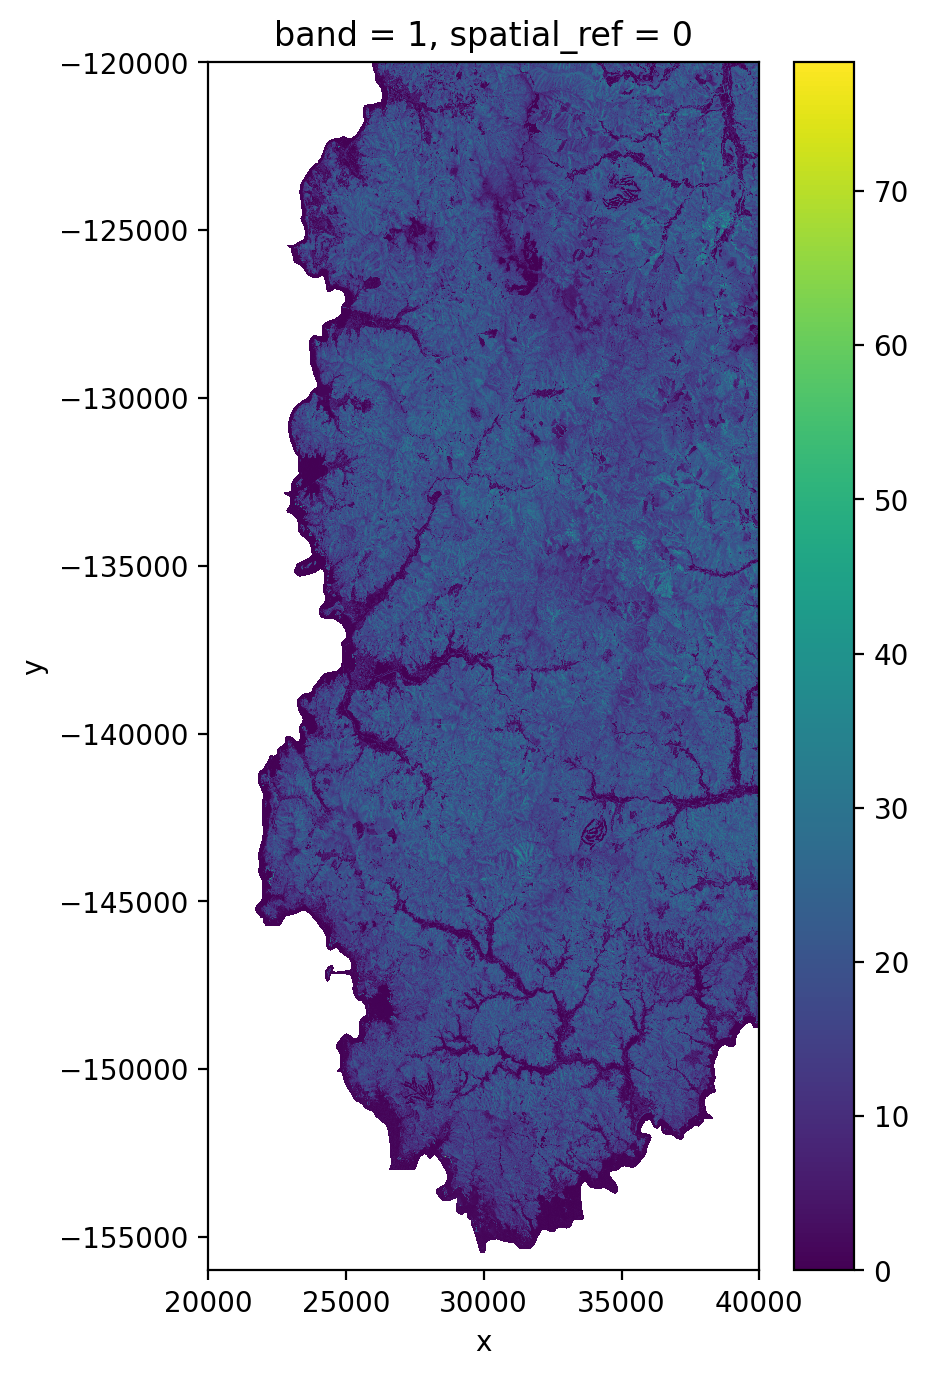

In [8]:
tree_height.plot(size=8, aspect=tree_height.coords['x'].size / tree_height.coords['y'].size)

樹高のヒストグラムを表示する。

(array([1.056043e+06, 4.213240e+05, 2.995640e+05, 2.900560e+05,
        3.000070e+05, 3.017070e+05, 3.116780e+05, 3.260830e+05,
        3.447870e+05, 4.032110e+05, 4.958850e+05, 6.204430e+05,
        7.699590e+05, 9.400600e+05, 1.115979e+06, 1.285199e+06,
        1.424749e+06, 1.516285e+06, 1.535122e+06, 1.475582e+06,
        1.344912e+06, 1.167219e+06, 9.664100e+05, 7.618880e+05,
        5.681900e+05, 4.064690e+05, 2.758880e+05, 1.806520e+05,
        1.135760e+05, 7.027600e+04, 4.293600e+04, 2.557700e+04,
        1.527300e+04, 9.357000e+03, 5.945000e+03, 3.808000e+03,
        2.331000e+03, 1.582000e+03, 1.082000e+03, 6.420000e+02,
        4.420000e+02, 3.000000e+02, 1.800000e+02, 1.580000e+02,
        1.040000e+02, 6.700000e+01, 6.000000e+01, 5.200000e+01,
        3.600000e+01, 2.200000e+01, 2.300000e+01, 1.100000e+01,
        4.000000e+00, 1.000000e+01, 5.000000e+00, 4.000000e+00,
        7.000000e+00, 9.000000e+00, 4.000000e+00, 6.000000e+00,
        2.000000e+00, 1.000000e+00, 1.00

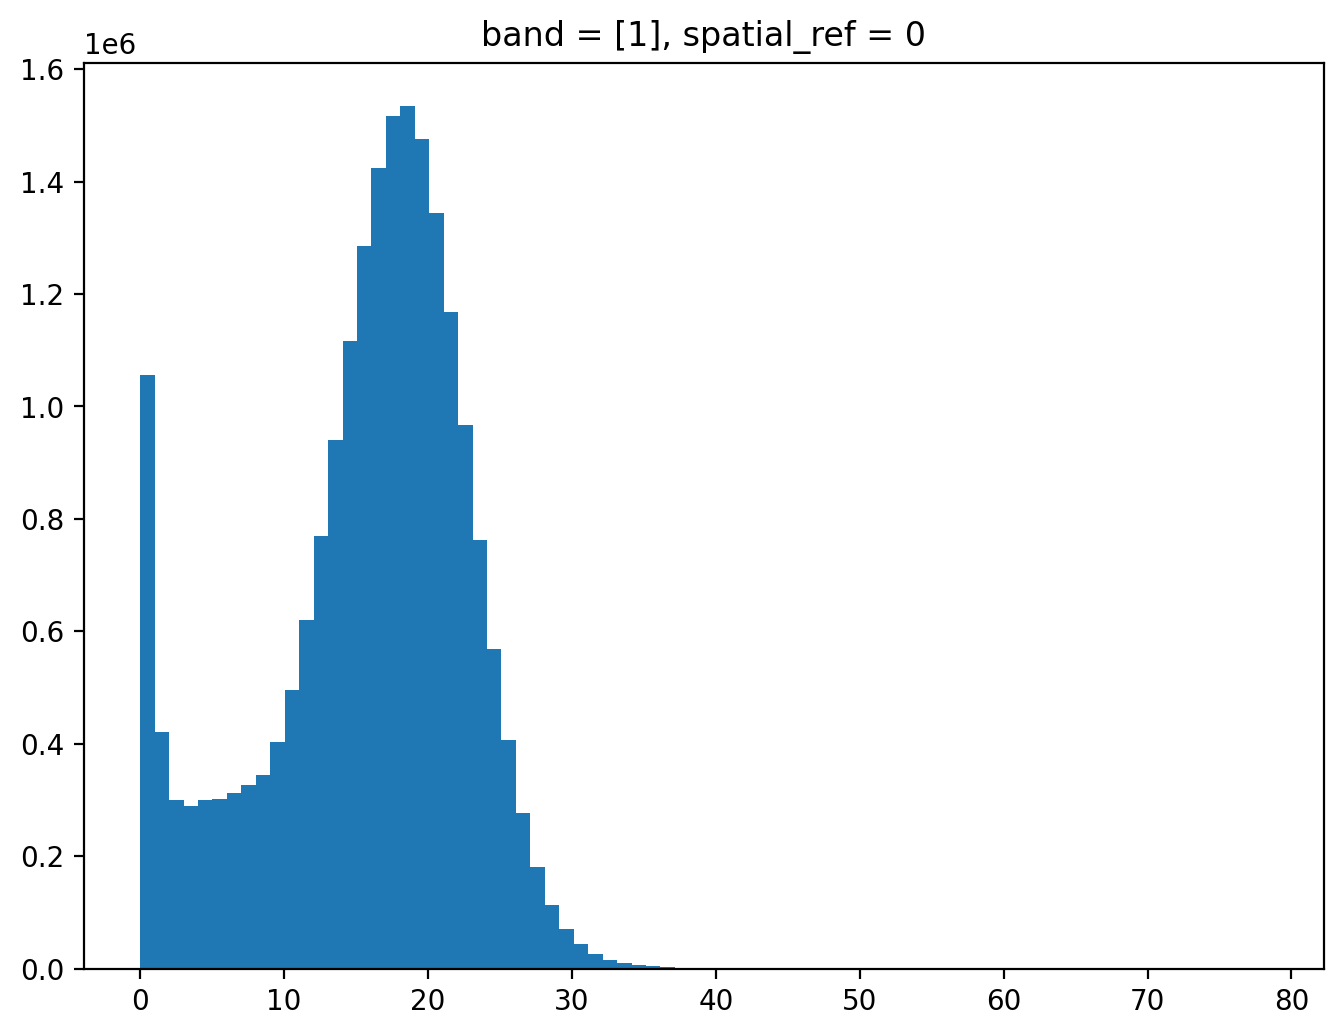

In [9]:
tree_height.plot.hist(bins=int(tree_height.max()))

被雲率の低い伊豆の Sentinel-2 データを Earth Search で検索する。

In [10]:
from pystac_client import Client

client = Client.open('https://earth-search.aws.element84.com/v0')
res = client.search(
    collections='sentinel-s2-l2a-cogs',
    bbox=tree_height.rio.reproject('EPSG:4326').rio.bounds(),
    datetime='2022',
    query=['eo:cloud_cover<1', 'sentinel:valid_cloud_cover=true']
)
res.matched()

6

In [11]:
item = min(res.items(), key=lambda item: item.properties['eo:cloud_cover'])
item

<Item id=S2A_54STD_20220412_0_L2A>

In [12]:
from IPython.display import Image
Image(url=item.assets['thumbnail'].href)

検索結果のバンドデータを樹高データに合わせて再投影し、NDVI を計算する。

In [13]:
bands = {}
for band_name in ['B04', 'B08']:
  band = rioxarray.open_rasterio(item.assets[band_name].href)
  band = band.rio.reproject_match(tree_height)
  bands[band_name] = band.astype('float64')

ndvi = (bands['B08'] - bands['B04']) / (bands['B08'] + bands['B04'])
ndvi

<xarray.DataArray (band: 1, y: 7200, x: 4000)>
array([[[-0.04942966, -0.04942966, -0.01845018, ...,         nan,
                 nan,         nan],
        [-0.04942966, -0.04942966, -0.07575758, ...,         nan,
                 nan,         nan],
        [-0.03971119, -0.03971119, -0.07575758, ...,         nan,
                 nan,         nan],
        ...,
        [-0.02857143, -0.1038961 , -0.1038961 , ...,         nan,
                 nan,         nan],
        [-0.05882353, -0.07142857, -0.07142857, ...,         nan,
                 nan,         nan],
        [-0.05882353, -0.07142857, -0.07142857, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * x            (x) float64 2e+04 2.001e+04 2.001e+04 ... 3.999e+04 4e+04
  * y            (y) float64 -1.2e+05 -1.2e+05 -1.2e+05 ... -1.56e+05 -1.56e+05
  * band         (band) int64 1
    spatial_ref  int64 0

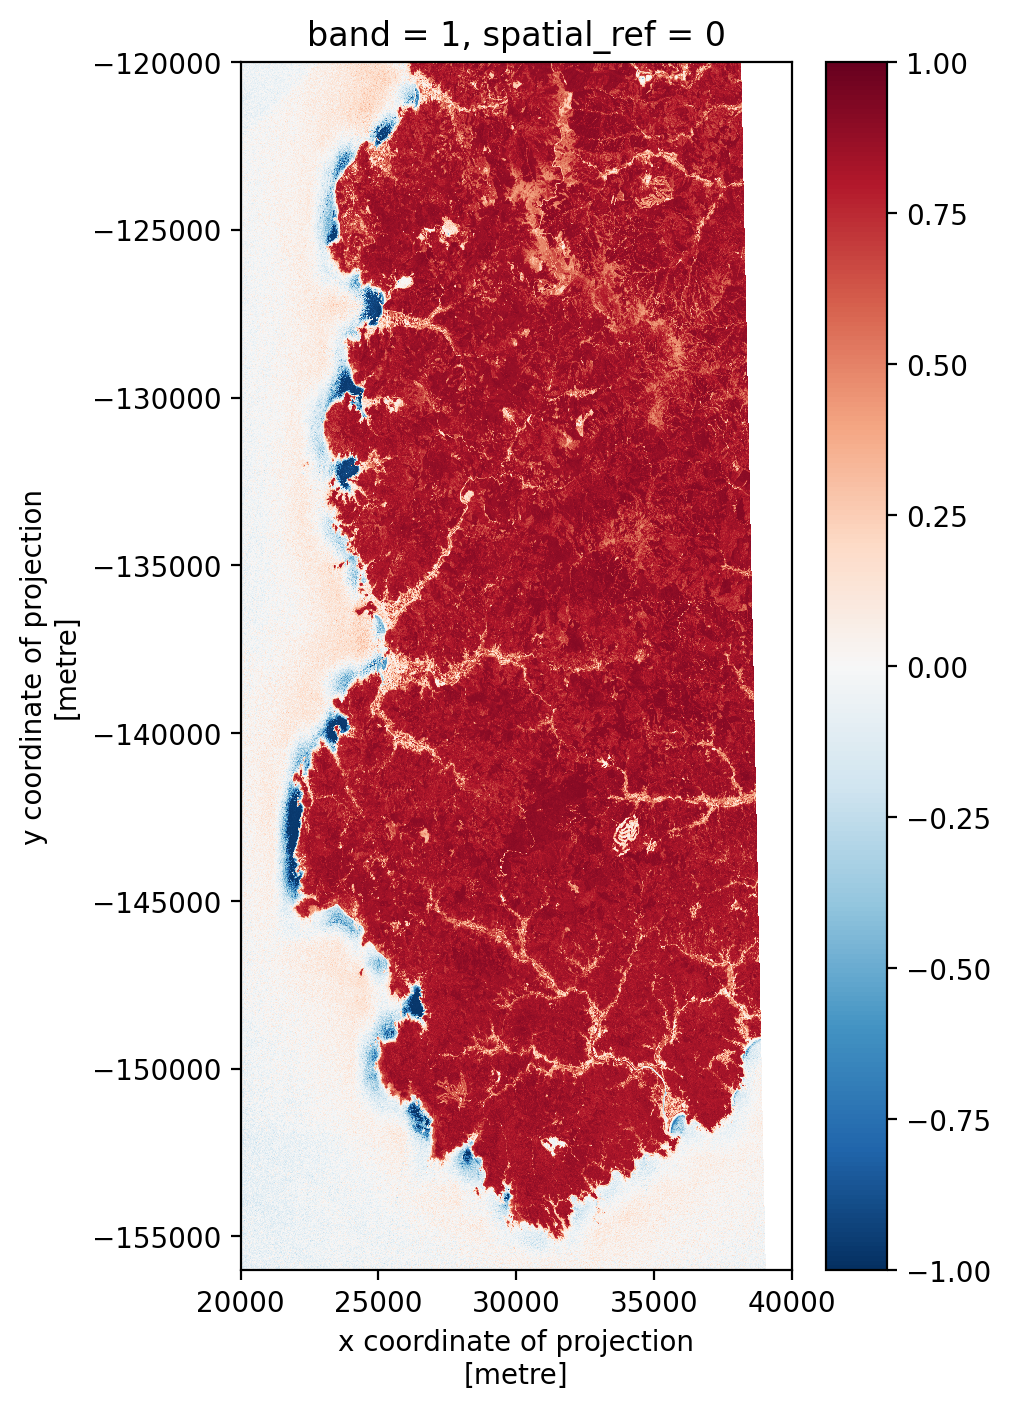

In [14]:
ndvi.plot(size=8, aspect=ndvi.coords['x'].size / ndvi.coords['y'].size)

NDVI のヒストグラムを表示する。

(array([6.311000e+03, 6.763500e+04, 2.377400e+04, 9.987000e+03,
        5.386000e+03, 3.848000e+03, 4.825000e+03, 4.559000e+03,
        4.917000e+03, 5.200000e+03, 5.671000e+03, 5.612000e+03,
        6.212000e+03, 7.205000e+03, 7.601000e+03, 8.424000e+03,
        9.589000e+03, 1.044500e+04, 1.237800e+04, 1.311300e+04,
        1.484000e+04, 1.678200e+04, 1.812800e+04, 2.098700e+04,
        2.401400e+04, 2.400600e+04, 3.401700e+04, 3.416300e+04,
        3.849600e+04, 4.434200e+04, 5.394100e+04, 7.050200e+04,
        9.856400e+04, 1.528980e+05, 2.438730e+05, 3.969250e+05,
        5.896640e+05, 7.962500e+05, 8.884920e+05, 1.090308e+06,
        9.634370e+05, 8.121440e+05, 5.969790e+05, 4.093870e+05,
        2.641060e+05, 1.701090e+05, 1.163230e+05, 8.812100e+04,
        7.286000e+04, 6.769200e+04, 6.631600e+04, 6.691300e+04,
        6.903300e+04, 7.370900e+04, 8.001800e+04, 8.889300e+04,
        1.004570e+05, 1.148140e+05, 1.286000e+05, 1.396690e+05,
        1.572930e+05, 1.758100e+05, 1.99

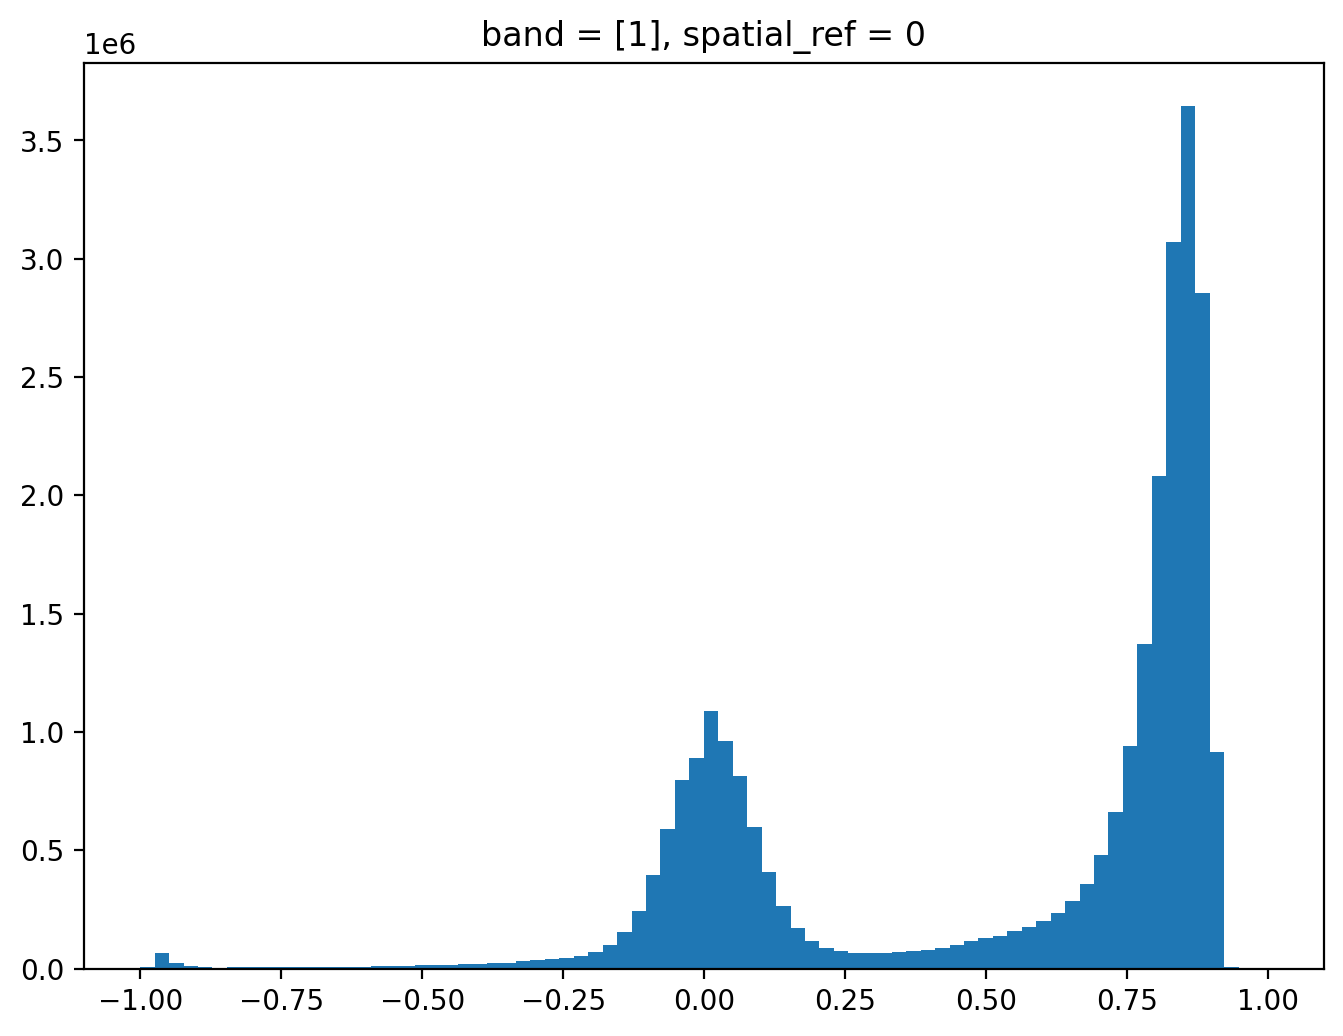

In [15]:
ndvi.plot.hist(bins=int(tree_height.max()))

### 教師データ作成のための点データ準備

樹高、NDVI それぞれについて一定間隔のメッシュの値を抽出し、データセットとする。

In [16]:
import numpy as np
import geopandas as gpd

x_min, y_min, x_max, y_max = tree_height.rio.bounds()
interval = 500 # meters
sample_x = np.arange(x_min, x_max, interval)
sample_y = np.arange(y_min, y_max, interval)

sample_mesh_x, sample_mesh_y = np.meshgrid(
    np.arange(x_min, x_max, interval),
    np.arange(y_min, y_max, interval)
)

dataset_gdf = gpd.GeoDataFrame({
    'geometry': gpd.points_from_xy(x=sample_mesh_x.ravel(), y=sample_mesh_y.ravel()),
    'tree_height': tree_height.interp(x=sample_x, y=sample_y).values.ravel(),
    'ndvi': ndvi.interp(x=sample_x, y=sample_y).values.ravel(),
})
dataset_gdf.dropna(inplace=True)
dataset_gdf

geometry  tree_height      ndvi
100   POINT (30000.000 -155000.000)     0.786803  0.060870
101   POINT (30500.000 -155000.000)     1.362453 -0.170165
102   POINT (31000.000 -155000.000)     1.073065 -0.075317
103   POINT (31500.000 -155000.000)     3.440059  0.346561
140   POINT (30000.000 -154500.000)     2.356022  0.670778
...                             ...          ...       ...
2872  POINT (36000.000 -120500.000)     0.054886  0.376098
2873  POINT (36500.000 -120500.000)     2.012703  0.569648
2874  POINT (37000.000 -120500.000)    22.811410  0.847636
2875  POINT (37500.000 -120500.000)    15.785563  0.841320
2876  POINT (38000.000 -120500.000)    19.905503  0.779397

[1933 rows x 3 columns]

樹高、NDVI のマップ上に値を抽出した地点を表示する。

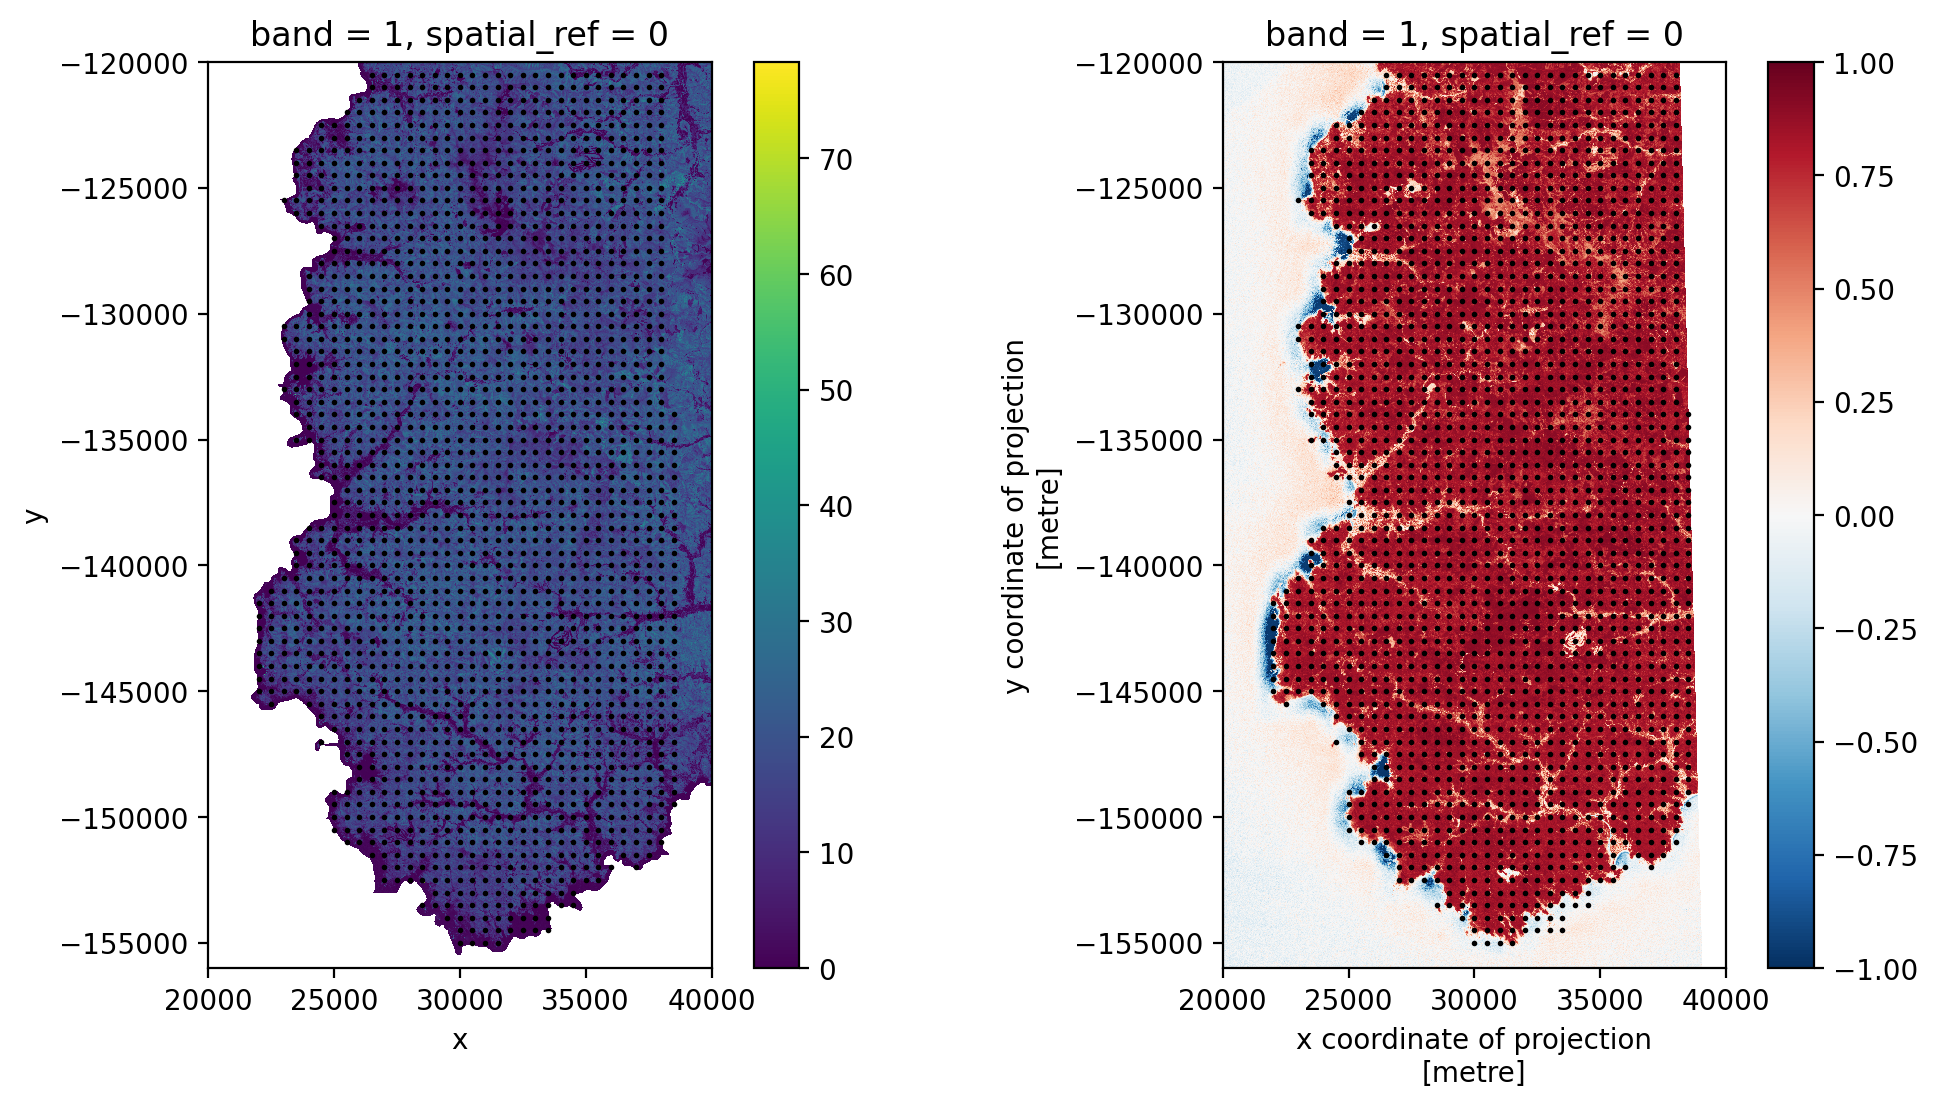

In [17]:
_fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax, data in zip(axs, [tree_height, ndvi]):
  data.plot(ax=ax)
  dataset_gdf.plot(ax=ax, color='black', markersize=1)

### 線形回帰の実行

作成したデータセットを訓練データとテストデータに分割する。

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    dataset_gdf['ndvi'].values.reshape(-1, 1),
    dataset_gdf['tree_height'].values.reshape(-1, 1),
    test_size=0.2,
    random_state=42
)
X_train.size, X_test.size

(1546, 387)

訓練データで線形回帰モデルを作成する。

In [19]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.38930153185297267

樹高と NDVI の散布図上に作成した線形回帰モデルをプロットする。

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


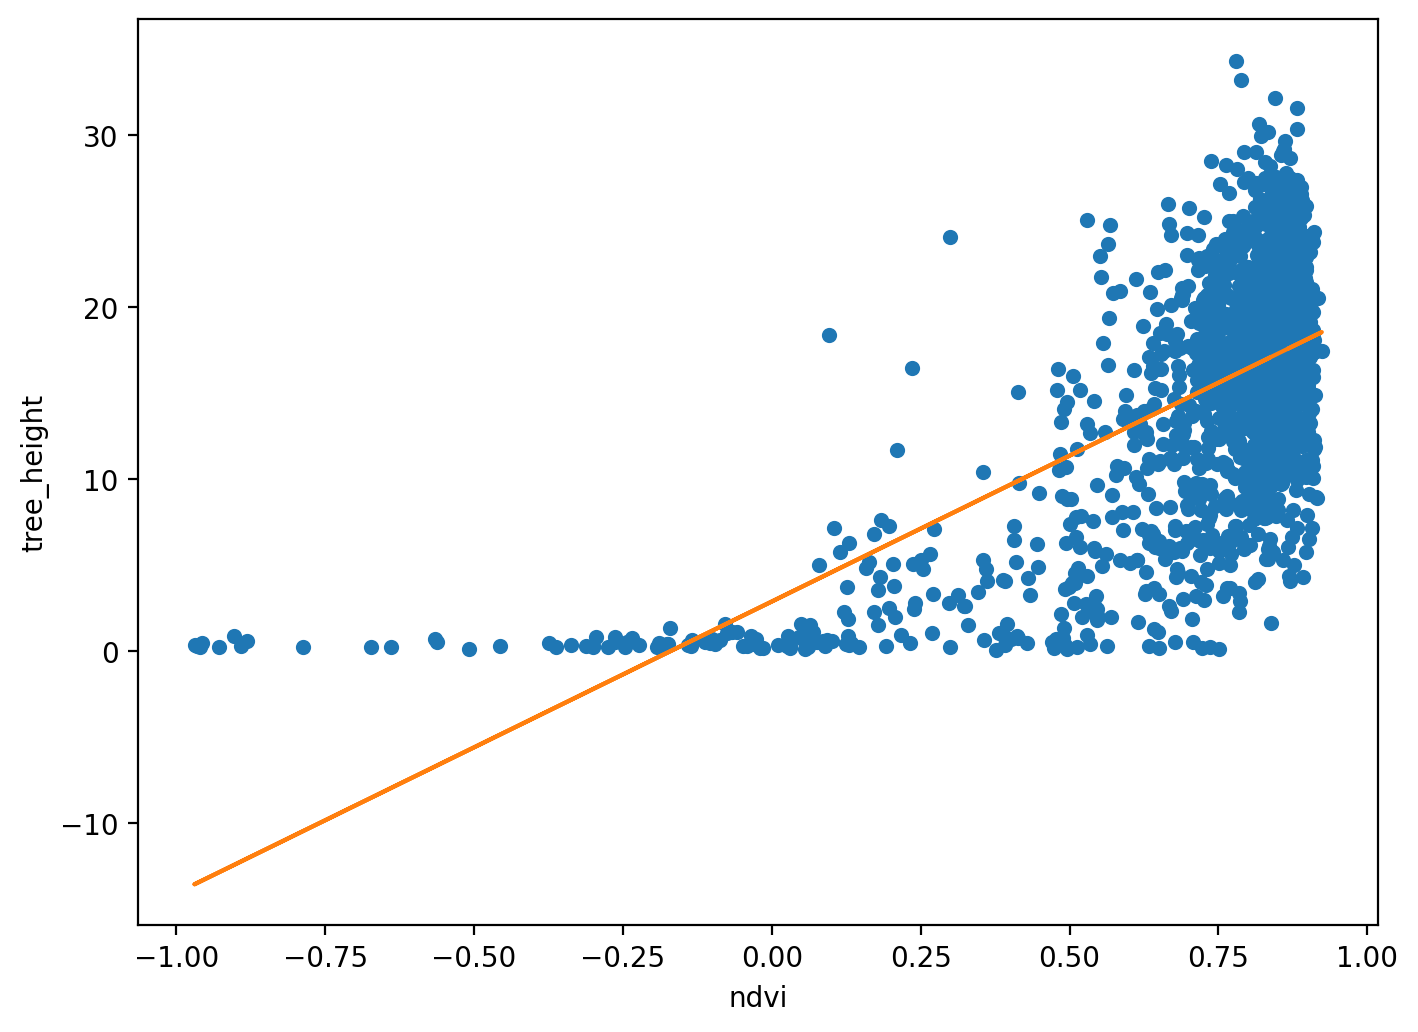

In [20]:
ax = dataset_gdf.plot.scatter(x='ndvi', y='tree_height')
ax.plot(X_train, reg.predict(X_train), color='C1')

テストデータにおける決定係数と二乗平均平方根誤差（RMSE）を求める。

In [21]:
reg.score(X_test, y_test)

0.37779118067527484

In [22]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true=y_test, y_pred=reg.predict(X_test), squared=False)

5.100740172650614

## 5-2 サポートベクターマシン

サポートベクターマシンの回帰モデルを作成し、テストデータにおける決定係数と RMSE を求める。

In [23]:
from sklearn.svm import SVR
svr = SVR().fit(X_train, y_train.ravel())
svr.score(X_train, y_train)

0.4484724408337033

In [24]:
svr.score(X_test, y_test)

0.4233738034534398

In [25]:
mean_squared_error(y_true=y_test, y_pred=svr.predict(X_test), squared=False)

4.910348368876699